### This Notebook Written By Bilge Kaan Gürgen

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
class veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [3]:
dataset = veri(
    csv_file=r"D:\udemyaicourse\Main\Pytorch Preprocess, Train, Prediction\formula_data_and_label\label\labelf1.csv",
    root_dir=r"D:\udemyaicourse\Main\Pytorch Preprocess, Train, Prediction\formula_data_and_label\images",
    transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(28,28)),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ]))

In [4]:
dataset

In [5]:
train_set, test_set = torch.utils.data.random_split(dataset, [200, 79])
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

In [6]:
train_set

In [7]:
train_loader

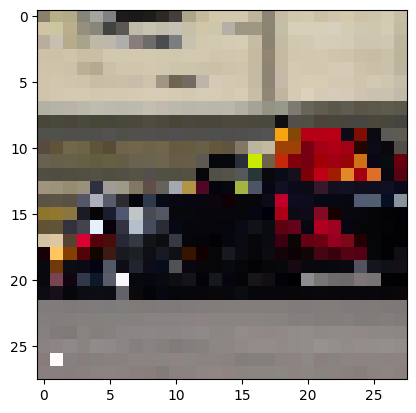

Redbull
torch.Size([1, 3, 28, 28])


In [8]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 1
classes = ["Ferrari", "McLaren","Mercedes","Redbull"]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())

In [9]:
import torch.nn as nn

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, (5,5))
        self.conv2 = nn.Conv2d(4, 8, (3,3))
        self.conv3 = nn.Conv2d(8, 16, (2,2))
        self.conv4 = nn.Conv2d(16, 32, (2,2))


        self.max = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.func = nn.ELU()
        self.func1 = nn.ReLU()

        self.fc1 = nn.Linear(64, 50) # tensorflow da dense diye geçiyor torch da lineer
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 100)
        self.fc4 = nn.Linear(100, 4)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.func(x)

        x = self.max(x)

        x = self.conv2(x)
        x = self.func(x)

        x = self.max(x)

        x = self.conv3(x)
        x = self.func(x)

        x = self.max(x)

        x =x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        x = self.func(x)
        x = self.fc3(x)
        x = self.func(x)
        x = self.fc4(x)
        x = self.func(x)

        return x

# Tensorboard install


In [11]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [18]:
start = time.time()

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


parametre= dict(lr=[0.1, 0.01, 0.001], batch_size=[1,2])
parametre_values = [v for v in parametre.values()]

from itertools import product
from torch.utils.tensorboard import SummaryWriter

for lr, batch_size in product(*parametre_values):

    model = Net()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    error = nn.CrossEntropyLoss()

    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)

    tensorboard = SummaryWriter(comment=f'batch_size={batch_size} lr={lr}')
    tensorboard.add_image('images', grid)
    tensorboard.add_graph(model, images)

    for epoch in range(5):
        total_loss = 0
        total_correct = 0

        for i,(images,labels) in enumerate (train_loader):
            preds = model(images)
            loss = error(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            total_correct += get_num_correct(preds, labels)

        tensorboard.add_scalar('Loss', total_loss, epoch)
        tensorboard.add_scalar('Number Correct', total_correct, epoch)
        tensorboard.add_scalar('Accuracy', total_correct/len(train_set), epoch)
        tensorboard.add_hparams({"lr": lr, "batch_size": batch_size}, 
        {"accuracy": total_correct/len(train_set), "loss": total_loss})


        for name,param in model.named_parameters():
            tensorboard.add_histogram(name, param, epoch)

        print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss)
        tensorboard.close()   

end = time.time()
print("süre:", end-start)

epoch 0 total_correct: 49 loss: 575.1561822891235
epoch 1 total_correct: 51 loss: 277.25887298583984
epoch 2 total_correct: 51 loss: 277.25887298583984
epoch 3 total_correct: 51 loss: 277.25887298583984
epoch 4 total_correct: 51 loss: 277.25887298583984
epoch 0 total_correct: 50 loss: 12158.135392189026
epoch 1 total_correct: 51 loss: 554.5177459716797
epoch 2 total_correct: 51 loss: 554.5177459716797
epoch 3 total_correct: 51 loss: 554.5177459716797
epoch 4 total_correct: 51 loss: 554.5177459716797
epoch 0 total_correct: 48 loss: 292.5259252637625
epoch 1 total_correct: 52 loss: 277.28316938877106
epoch 2 total_correct: 58 loss: 277.15849351882935
epoch 3 total_correct: 50 loss: 333.53292882442474
epoch 4 total_correct: 51 loss: 277.25887298583984
epoch 0 total_correct: 59 loss: 610.5600322857499
epoch 1 total_correct: 55 loss: 566.9774369001389
epoch 2 total_correct: 49 loss: 554.5188066959381
epoch 3 total_correct: 48 loss: 554.5179495811462
epoch 4 total_correct: 47 loss: 554.51788

In [19]:
tensorboard --logdir=runs

SyntaxError: can't assign to operator (3224537314.py, line 1)